Saving telescope.jpg to telescope.jpg


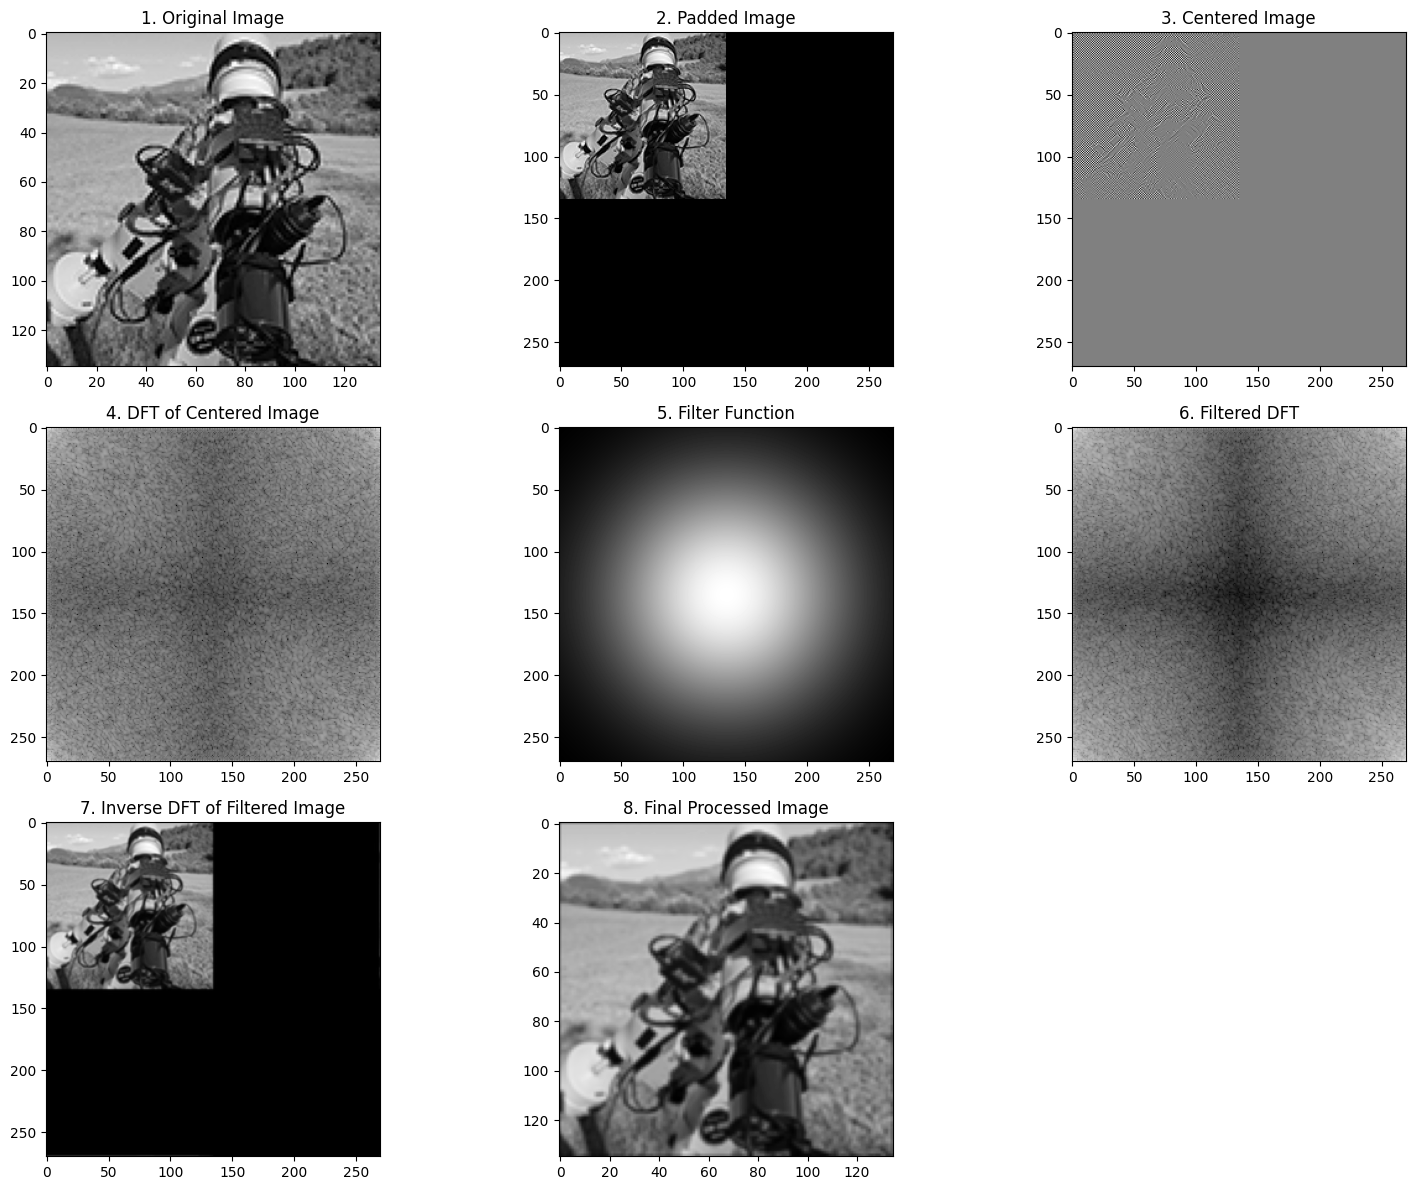

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from google.colab import files
from PIL import Image

# Step 1: Upload an image
uploaded = files.upload()
filename = next(iter(uploaded))
image = Image.open(filename).convert('L')  # Convert to grayscale
img_array = np.array(image)

# Step 2: Pad the image
M, N = img_array.shape
P, Q = 2 * M, 2 * N
padded_img = np.pad(img_array, ((0, M), (0, N)), mode='constant', constant_values=0)

# Step 3: Center the transform
centered_img = np.zeros((P, Q))
for x in range(P):
    for y in range(Q):
        centered_img[x, y] = padded_img[x, y] * ((-1)**(x + y))

# Step 4: Compute DFT
dft = fft2(centered_img)

# Step 5: Generate real symmetric filter function
X, Y = np.ogrid[:P, :Q]
center = (P // 2, Q // 2)
dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
filter_func = np.exp(-(dist_from_center**2) / (2 * (P/4)**2))

# Step 6: Multiply DFT result with the filter
filtered_dft = dft * filter_func

# Step 7: Inverse DFT and apply centering transformation
processed_img = ifft2(filtered_dft).real
centered_processed_img = np.zeros((P, Q))
for x in range(P):
    for y in range(Q):
        centered_processed_img[x, y] = processed_img[x, y] * ((-1)**(x + y))

# Step 8: Extract the original image size
final_img = centered_processed_img[:M, :N]

# Plot and show all outputs
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1), plt.imshow(img_array, cmap='gray'), plt.title('1. Original Image')
plt.subplot(3, 3, 2), plt.imshow(padded_img, cmap='gray'), plt.title('2. Padded Image')
plt.subplot(3, 3, 3), plt.imshow(centered_img, cmap='gray'), plt.title('3. Centered Image')
plt.subplot(3, 3, 4), plt.imshow(np.log(1 + np.abs(fftshift(dft))), cmap='gray'), plt.title('4. DFT of Centered Image')
plt.subplot(3, 3, 5), plt.imshow(filter_func, cmap='gray'), plt.title('5. Filter Function')
plt.subplot(3, 3, 6), plt.imshow(np.log(1 + np.abs(fftshift(filtered_dft))), cmap='gray'), plt.title('6. Filtered DFT')
plt.subplot(3, 3, 7), plt.imshow(centered_processed_img, cmap='gray'), plt.title('7. Inverse DFT of Filtered Image')
plt.subplot(3, 3, 8), plt.imshow(final_img, cmap='gray'), plt.title('8. Final Processed Image')

plt.tight_layout()
plt.show()


Saving 22.jpg to 22.jpg


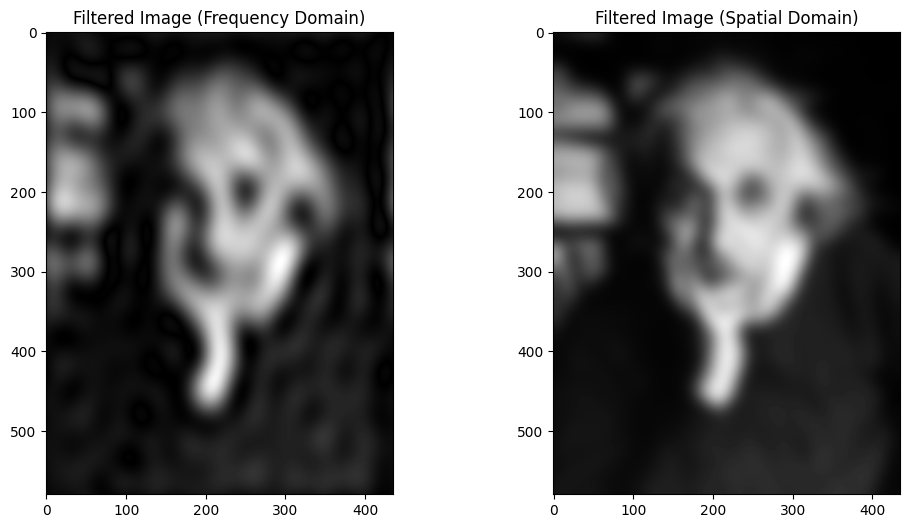

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
import cv2
from google.colab import files
from scipy.ndimage import gaussian_filter

def load_image(upload_prompt):
    uploaded = files.upload()
    filename = next(iter(uploaded))
    image = cv2.imread(filename, 0)  # Read as grayscale
    return image

def apply_filter_frequency_domain(image, filter_type, filter_param):
    # Fourier transform
    f_transform = fft2(image)
    f_transform_shifted = fftshift(f_transform)

    # Apply filter
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)
    # low-pass filter
    cv2.circle(mask, (ccol, crow), filter_param, 1, -1)
    f_transform_shifted *= mask

    # Inverse Fourier transform
    f_ishift = np.fft.ifftshift(f_transform_shifted)
    img_back = np.abs(ifft2(f_ishift))
    return img_back

def apply_filter_spatial_domain(image, filter_type, filter_param):
  return gaussian_filter(image, sigma=filter_param)

image = load_image("Please upload an image:")

filtered_image_frequency = apply_filter_frequency_domain(image, filter_type, filter_param)
filtered_image_spatial = apply_filter_spatial_domain(image, filter_type, filter_param)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(filtered_image_frequency, cmap='gray')
plt.title('Filtered Image (Frequency Domain)')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_spatial, cmap='gray')
plt.title('Filtered Image (Spatial Domain)')

plt.show()


Saving 22.jpg to 22 (8).jpg
Enter Gaussian kernel size (odd number, e.g., 5):15
Enter Gaussian sigma (e.g., 1.0):5



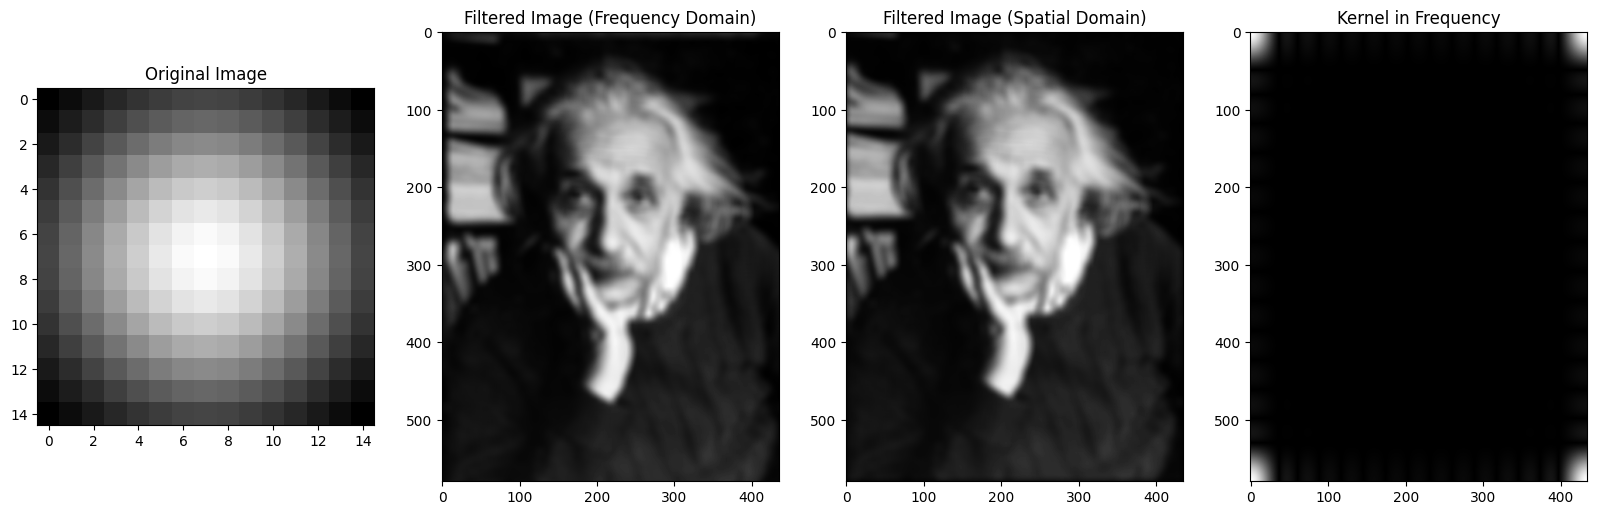

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
import cv2
from google.colab import files

def load_image(upload_prompt):
    uploaded = files.upload()
    filename = next(iter(uploaded))
    image = cv2.imread(filename, 0)  # Read as grayscale
    return image

def create_gaussian_kernel(size, sigma):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)

def apply_filter_frequency_domain(image, kernel):
    # Fourier transform of image and kernel
    f_transform_image = fft2(image)
    f_transform_kernel = fft2(kernel, s=image.shape)

    # Multiply in frequency domain (convolution in spatial domain)
    f_transform_result = f_transform_image * f_transform_kernel

    # Inverse Fourier transform
    result = np.abs(ifft2(f_transform_result))
    return result, f_transform_kernel

def apply_filter_spatial_domain(image, kernel):
    # Convolution
    result = np.zeros_like(image)
    image_padded = np.pad(image, [(kernel.shape[0]//2, kernel.shape[0]//2),
                                  (kernel.shape[1]//2, kernel.shape[1]//2)], mode='constant')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.sum(image_padded[i:i+kernel.shape[0], j:j+kernel.shape[1]] * kernel)
    return result

# Main
image = load_image("Please upload an image:")
kernel_size = int(input("Enter Gaussian kernel size (odd number, e.g., 5):"))
sigma = float(input("Enter Gaussian sigma (e.g., 1.0):"))

gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
print()

filtered_image_frequency, f_transform_kernel = apply_filter_frequency_domain(image, gaussian_kernel)
filtered_image_spatial = apply_filter_spatial_domain(image, gaussian_kernel)

# Plotting
plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(gaussian_kernel, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(filtered_image_frequency, cmap='gray')
plt.title('Filtered Image (Frequency Domain)')

plt.subplot(1, 4, 3)
plt.imshow(filtered_image_spatial, cmap='gray')
plt.title('Filtered Image (Spatial Domain)')

plt.subplot(1, 4, 4)
plt.imshow(np.abs(f_transform_kernel), cmap='gray')
plt.title('Kernel in Frequency')

plt.show()


Saving Einstein_ledeNew.jpg to Einstein_ledeNew (2).jpg


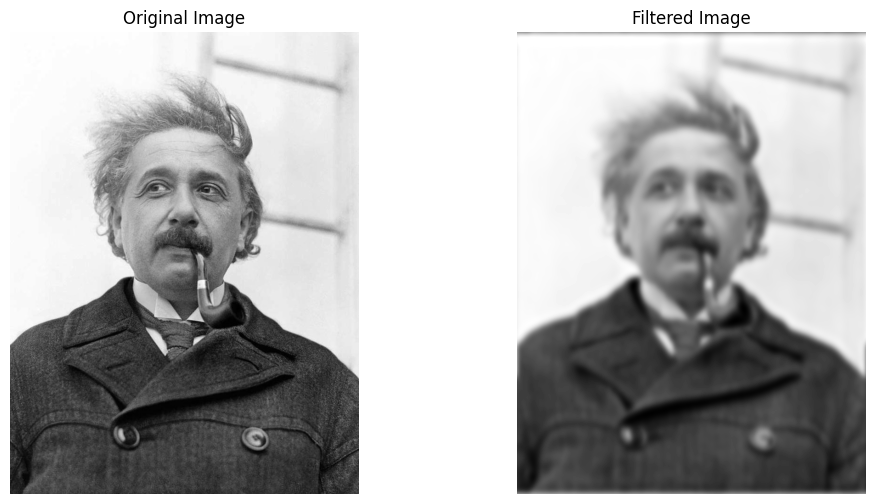

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from google.colab import files
from PIL import Image
import io

def butterworth_lowpass_filter(shape, cutoff, order):
    P, Q = shape
    D0 = cutoff
    H = np.zeros((P, Q))

    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u - P / 2)**2 + (v - Q / 2)**2)
            H[u, v] = 1 / (1 + (D / D0)**(2 * order))
    return H

def apply_filter(img, filter_func):
    img_fft = fftshift(fft2(img))
    filtered_fft = img_fft * filter_func
    filtered_img = np.abs(ifft2(np.fft.ifftshift(filtered_fft)))
    return np.clip(filtered_img, 0, 255)

# Upload an image
uploaded = files.upload()
filename = next(iter(uploaded))
image = Image.open(io.BytesIO(uploaded[filename])).convert('L') # Convert to grayscale
image_np = np.array(image)

# Apply Butterworth lowpass filter
cutoff_frequency = 30
order = 2
filter_func = butterworth_lowpass_filter(image_np.shape, cutoff_frequency, order)
filtered_image = apply_filter(image_np, filter_func)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.show()
